In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [2]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


In [3]:
# Import the Speech Commands dataset

data_dir = pathlib.Path('/content/drive/MyDrive/mini_speech_commands')
# if not data_dir.exists():
#   tf.keras.utils.get_file(
#     'mini_speech_commands.zip',
#     origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
#     extract=True,
#     cache_dir='.', cache_subdir='data')

In [4]:
#Check basic statistics about the dataset.

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
commands = commands[commands != 'NO.wav']
commands = commands[commands != 'YES.wav']
print('Commands:', commands)

Commands: ['yes' 'up' 'stop' 'right' 'no' 'left' 'go' 'down']


In [35]:
#Extract the audio files into a list and shuffle it.

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8040
Number of examples per label: 1010
Example file tensor: tf.Tensor(b'/content/drive/MyDrive/mini_speech_commands/up/b8b8cb52_nohash_0.wav', shape=(), dtype=string)


In [6]:
#Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.

train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [7]:
# Reading audio files and their labels
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)
#The label for each WAV file is its parent directory.

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note:use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]


#Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

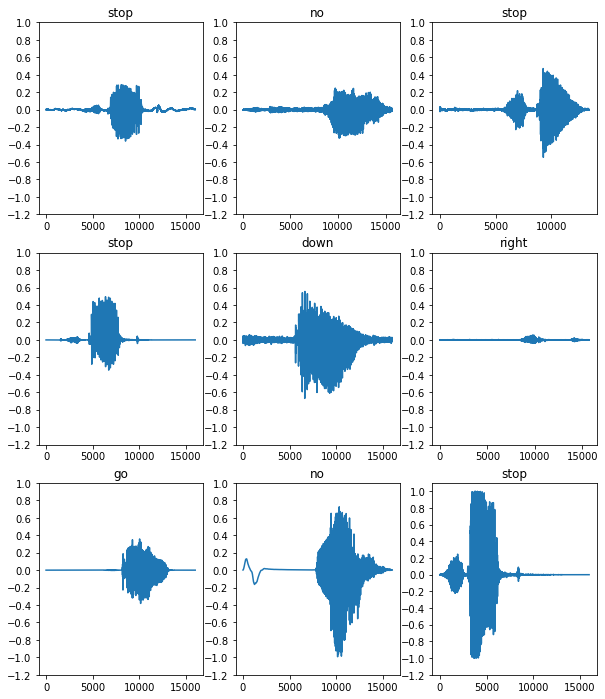

In [8]:
#You'll now apply `process_path` to build your training set to extract the audio-label pairs and check the results.You'll build the validation and test sets using a similar procedure later on.

AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

#Let's examine a few audio waveforms with their corresponding labels.

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [9]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)
  return spectrogram

In [10]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


In [11]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

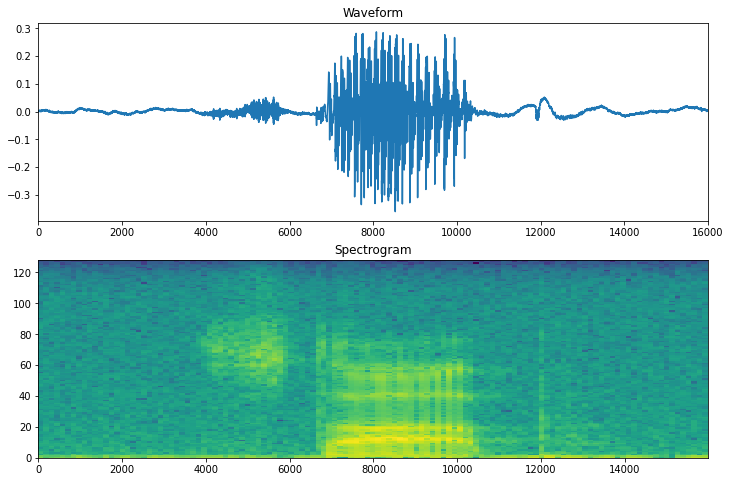

In [12]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [13]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [14]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


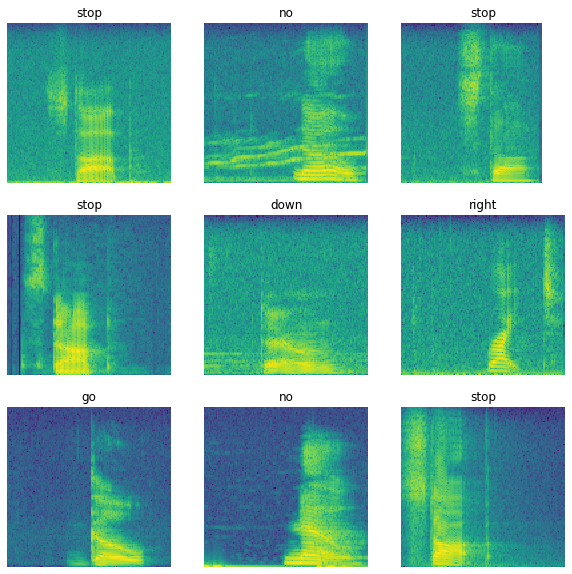

In [15]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

In [16]:
#Build and train the model
#Now you can build and train your model. But before you do that, you'll need to repeat the training set preprocessing on the validation and test sets.


def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [17]:
#Batch the training and validation sets for model training.

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)


train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [19]:
#For the model, I'll use a simple convolutional neural network (CNN), since I have transformed the audio files into spectrogram images.

for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

Input shape: (124, 129, 1)


In [20]:
#For Building a new model and training it, uncomment the following commented parts below (in orange color not the green ones)


model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 10231402
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

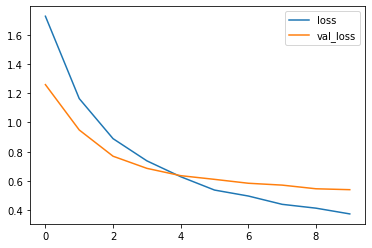

In [25]:
#Let's check the training and validation loss curves to see how your model has improved during training.

metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()


In [26]:
# Evaluate test set performance
#Let's run the model on the test set and check performance.

test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')


Test set accuracy: 82%


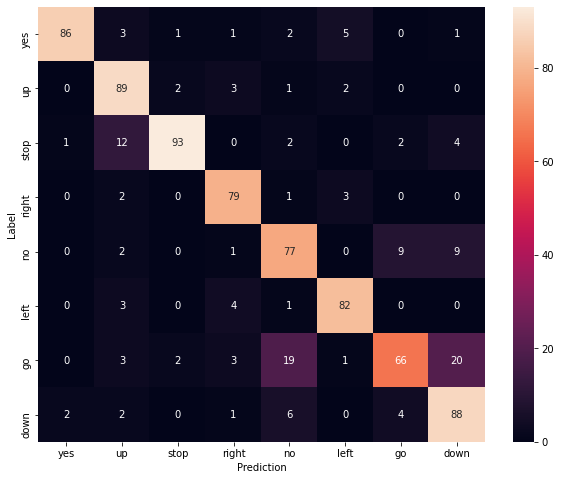

In [27]:
# Display a confusion matrix.
#A confusion matrix is helpful to see how well the model did on each of the commands in the test set.

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


In [32]:
#Now lets save the model (In order to avoid the training process in case of retesting)
model.save('/content/drive/MyDrive/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/assets


In [33]:
# Run inference on an audio file
#Now order the LED status
order=int(input("Enter 1 if you want to turn the LED on and enter 2 if you like to keep it off. \n"))
if order==1:
  sample_file = data_dir/'YES.wav'
  sample_ds = preprocess_dataset([str(sample_file)])
elif order==2:
  sample_file = data_dir/'NO.wav'
  sample_ds = preprocess_dataset([str(sample_file)])
#Load the saved model by entering its path 
model = tf.keras.models.load_model('/content/drive/MyDrive/')

Enter 1 if you want to turn the LED on and enter 2 if you like to keep it off. 
1


In [ ]:
#The Next commented lines are in case of existence of an LED using Raspberry Pi. There should be another complementory code for getting a voice from a USB microphone and converting it to an audio file using Raspberry Pi which is provided in a sperated file.

"""
from gpiozero import LED
from time import sleep
led=LED(17)
"""

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  listval = list(tf.nn.softmax(prediction[0]).numpy())
  i =0
  max = 0
  max_i = 0
  for val in listval:
    if val > max:
      max = val
      max_i = i
    i = i+1
  if commands[max_i]==commands[7]:
    print('LED on')
    #led.on()
  if commands[max_i]==commands[6]:
    print('LED off')
    #led.off()  
  print("Word: ",commands[max_i])
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[max_i]}"')
  plt.show()